# 기타 ML에 필요한 기법들

## GridsearchCV

### GridSearch란?
- 모델의 hyperparameter를 찾는 것을 도와주는 친구

### 메소드 모음
- **GridSearchCV ( estimator = , param_grid = , scoring = , cv = , n_jobs = , verbose = )** : grid search 하기
- **.best_scores_**: 최적의 score 점수를 보여줌
- **.best_estimator_**: 최적의 parameter로 설정된 모델을 생성
- **.best_params_**: 최적의 parameter를 반환
- **.cv_results_**: 전체적인 결과값들을 보여줌

In [0]:
## Catboost best parameter 찾는 과정
# 우선 부차적인 parameter 찾아주고
cb = CatBoostClassifier(
 learning_rate =0.1,
 iterations=100 #n-estimator대신 iteration을 사용,
)

cb_params_1 = {
    'depth' : [3,5,7],
    'random_strength' : [1,3],
    'bagging_temperature' : [0,0.5,1],
    'l2_leaf_reg' : [1,3,5,7],
}
cb_grid_1 = GridSearchCV(cb, param_grid=cb_params_1, scoring=my_scorer, cv=5, verbose=1)
cb_grid_1.fit(train[features], train['Survived'])

print("Best Score : {}".format(cb_grid_1.best_score_))
print("Best Params : {}".format(cb_grid_1.best_params_))
best_cb_model = cb_grid_1.best_estimator_

# 최적의 core parameter 찾기
cb_params_2 = {
    'learning_rate' : [0.03, 0.07, 0.1],
    'iterations' : [n for n in range(80,130,20)]
}
cb_grid_2 = GridSearchCV(best_cb_model, param_grid=cb_params_2, scoring=my_scorer, cv=5, verbose=1)
cb_grid_2.fit(train[features], train['Survived'])

print("Best Score : {}".format(cb_grid_2.best_score_))
print("Best Params : {}".format(cb_grid_2.best_params_))
best_cb_model = cb_grid_2.best_estimator_

In [0]:
### Xgboost best parameter 찾기
## 처음에는 부차적인 parameter를 tuning하기
# GridSearchCV에 들어갈 param_grid, estimator, scoring 만들어주기
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, f1_score, accuracy_score
my_scorer = make_scorer(accuracy_score, greater_is_better = True)

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
)

xgb_params_1 = {
    'max_depth' : [3,5,7],
    'min_child_weight' : [0.5, 1],
    'gamma' : [0, 0.1],
    'subsample' : [0.5, 0.7, 0.9],
    'colsample_bytree' : [0.5, 0.7, 0.9],
} #3x2x2x3x3=108가지 경우의 수

# GridSearchCV 돌리기
xgb_grid_1 = GridSearchCV(estimator=xgb1, param_grid=xgb_params_1, 
                          scoring=my_scorer, cv=5, n_jobs=1, verbose=1)
xgb_grid_1.fit(train[features], train['Survived']) # Titanic data

# 제일 좋은 모델 뽑기
print("Best Score : {}".format(xgb_grid_1.best_score_))
print("Best Params : {}".format(xgb_grid_1.best_params_))

# 표로 한 번 뽑아보고
results = pd.DataFrame(xgb_grid_1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results.head()

# 다시 Core parameter 설정!
best_xgb_model = xgb_grid_1.best_estimator_
xgb_params_2 = {
    'learning_rate' : [0.01, 0.05, 0.07, 0.1, 0.2],
    'n_estimators' : [n for n in range(100,200,20)]
}
xgb_grid_2 = GridSearchCV(best_xgb_model, param_grid=xgb_params_2, scoring=my_scorer, cv=5, verbose=1)
xgb_grid_2.fit(train[features], train['Survived'])

# 제일 좋은 모델 뽑기
print("Best Score : {}".format(xgb_grid_2.best_score_))
print("Best Params : {}".format(xgb_grid_2.best_params_))
best_xgb_model = xgb_grid_2.best_estimator_

In [0]:
# Linear regression, Ridge, Lasso 3개 중에서 10~49까지.

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

poly_range = list(range(10, 50))
rmse_lr_list = []
rmse_lasso_list = []
rmse_ridge_list = []

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

for poly_value in poly_range:
    poly_features = PolynomialFeatures(degree=poly_value)
    X_poly = poly_features.fit_transform(X)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_poly,y)
    rmse_lr_list.append(rmse(lr.predict(X_poly), y))

    lasso = Lasso(fit_intercept=False)
    lasso.fit(X_poly,y)
    rmse_lasso_list.append(rmse(lasso.predict(X_poly), y))
    
    ridge = Ridge(fit_intercept=False)
    ridge.fit(X_poly,y)
    rmse_ridge_list.append(rmse(ridge.predict(X_poly), y))
    
import pandas as pd
from pandas import DataFrame
data = {"poly_range":poly_range, "lr_rmse":rmse_lr_list, 
        "lasso_rmse":rmse_lasso_list,"ridge_rmse":rmse_ridge_list}
df = DataFrame(data).set_index("poly_range")
df

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2434.0457508985533, tolerance: 0.5525671213541011
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2438.905066476105, tolerance: 0.5525671213541011
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.85543e-18): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2435.357638648013, tolerance: 0.5525671213541011
  positive)
/usr/local/lib/python3.6/dist-

,lr_rmse,lasso_rmse,ridge_rmse
poly_range,,,
10,1.926541,2.320398,1.950333
11,1.920644,2.322260,1.933155
12,1.657890,2.322672,1.932618
13,1.377976,2.322120,1.906485
14,1.357432,2.321007,1.649491
15,0.950690,2.319717,1.516091
16,0.740613,2.318500,1.525275
17,0.698616,2.317491,1.321306
18,0.721070,2.316728,0.897234


In [0]:
print(df.min())
df["ridge_rmse"].sort_values().head()

lr_rmse       0.575616
lasso_rmse    2.315805
ridge_rmse    0.527321
dtype: float64


poly_range
24    0.527321
22    0.534591
23    0.545164
21    0.624743
20    0.762286
Name: ridge_rmse, dtype: float64

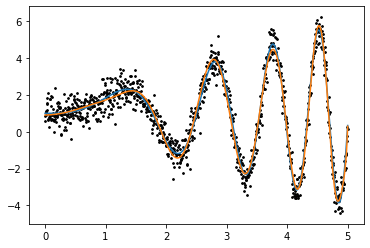

In [0]:
poly_features = PolynomialFeatures(degree=22)
X_poly = poly_features.fit_transform(X)
ridge = Ridge(fit_intercept=False)
ridge.fit(X_poly,y)

f_x, f_y = f(1000)
plt.plot(f_x, f_y)
plt.scatter(X.flatten(), y.flatten(), s=3, c="black")
plt.plot(X.flatten(), ridge.predict(X_poly).flatten())
plt.show()